In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [2]:
big_files_path = 'output/big_files/'
parsed_files_list =[big_files_path + 'data08_01_2017__11_33_36.csv',
                    big_files_path +  'data29_01_2017__11_09_32.csv',
                    big_files_path + 'data29_01_2017__12_21_52.csv',
                   #'output/big_files/data29_01_2017__10_29_57.csv'
                   ]
parsed_df = []
for parsed_file in parsed_files_list:
    df1 = pd.read_csv(parsed_file,sep=';',encoding='cp1251')
    if len(parsed_df)!=0:
        parsed_df = pd.concat([parsed_df,df1])
    else:
        parsed_df = df1.copy()
df = parsed_df.iloc[np.random.permutation(len(parsed_df))]
df = df.reset_index(drop=True)

### Convert data

In [3]:
import re
#Rooms
df['rooms'].value_counts()
df['rooms'] = df['rooms'].fillna(0)
rooms_int = []
for i in tqdm(range(len(df['rooms']))):
    if 'с' in str(df['rooms'].iloc[i]):
        rooms_int.append(0)
    else:
        rooms_int.append(  int(df['rooms'].iloc[i]) )
df['rooms_int'] = rooms_int

# Balcony
df['Balcony'].fillna('-')
Balcony_int =[]
#print(df['Balcony'].value_counts())
for i in range(len(df['Balcony'])):
    #print(df['Balcony'].iloc[i])
    list_n = re.findall(r'\b\d+\b',str(df['Balcony'].iloc[i]) )
    #print(list_n)
    if len(list_n)!=0:
        Balcony_int.append(sum(list(map(int, list_n))))
    else:
        Balcony_int.append(0)
df['Balcony_int']=Balcony_int

df['Lift'].fillna('-')
Lift_int = []
# Lift
for i in range(len(df['Lift'])):
    list_n = re.findall(r'\b\d+\b',str(df['Lift'].iloc[i]) )
    if len(list_n)!=0:
        Lift_int.append(sum(list(map(int, list_n))))
    else:
        Lift_int.append(0)
df['Lift_int']=Lift_int

100%|█████████████████████████████████████████████████████████████████████████| 18743/18743 [00:01<00:00, 18124.61it/s]


In [4]:
import re
import time
import math
df['Roof_hight'].fillna(0)
Roof_hight_fl = []
for i in tqdm(range(len(df['Lift']))):
    str1 = re.sub('м', '', str(df['Roof_hight'].iloc[i]))
    str1 = re.sub(' ', '', str1)
    str1 = re.sub(',', '', str1)
    a = float(str1)
    if a==a:
        a = a/10**math.trunc(math.log10(a))
    else:
        a=0
    Roof_hight_fl.append(a)
df['Roof_hight_fl'] = Roof_hight_fl

100%|█████████████████████████████████████████████████████████████████████████| 18743/18743 [00:00<00:00, 25397.69it/s]


#### Clean data

In [5]:
import time 
New_int=[]
for i in range(len(df)):
    a = df['Home_type'].iloc[i]
    if 'новостро' in a:
        New_int.append(1)
    elif 'вторич' in a:
        New_int.append(0)
    else:
        New_int.append(-1)
        print(a)
        print('Неопозннаый тип',end =' ')
        time.sleep(1)
df['New_int'] = New_int
df['Built_year'] = df['Built_year'].fillna(0)
df['Nfloor'] = df['Nfloor'].fillna(np.mean(df['Nfloor']))


In [6]:
sum(df['Kitsp'].isnull())

3518

In [7]:
from sklearn.model_selection import KFold
import time
features = ['Balcony_int','Built_year','Floor','New_int','Lift_int','Nfloor','Totsp','dist',
          'lat', 'lon','Kitsp']
#features = ['Totsp','lat', 'lon']

# 'Kitsp', 'Livesp','Metro_station', 'Metro_time', 'Parking' ,'Remont' ,'Sales_type', 'Tel','View', 'WC',
#       'Walk_metro', 'publication_date'
Y_test_pred_ALL = []
target_feature = 'Price'
out_filter = (df[target_feature]>1000000)& (df['Built_year']>1000)
df_clean = df[out_filter][features + [target_feature]].dropna()

kf = KFold(n_splits = 3,shuffle= False)
kf.get_n_splits(df_clean)
print('Start time:', time.strftime("%H:%M:%S"))
for train_index, test_index in kf.split(df_clean):
    #print("TRAIN:", train_index, "TEST:", test_index)

    #Y = np.array(df_clean[target_feature])
    #X = df_clean[features].as_matrix()

    #X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.33, random_state=42)
    X_train = df_clean[features].iloc[train_index].as_matrix()
    Y_train = df_clean[target_feature].iloc[train_index].as_matrix()
    X_test = df_clean[features].iloc[test_index].as_matrix()
    Y_test = df_clean[target_feature].iloc[test_index].as_matrix()

    #reg = GradientBoostingRegressor(n_estimators=1000)
    #reg = reg.fit(X_train, Y_train)
    #Y_test_pred=reg.predict(X_test)
    
    
    gbm = xgb.XGBRegressor(max_depth=10, n_estimators=5000).fit(X_train, Y_train)
    Y_test_pred = gbm.predict(X_test)
    Y_test_pred_ALL = np.append(Y_test_pred_ALL,Y_test_pred)
    print(time.strftime("%H:%M:%S"))
print('MAE')
Y_test_ALL = np.array(df_clean[target_feature])
print (mean_absolute_error(Y_test_ALL,Y_test_pred_ALL) )
#clf = clf.fit(X, Y)
#Y_test_pred=clf.predict(X_test)
print('Mean')
print(np.mean(Y_test))
Y_test= np.array(Y_test)
Y_test_pred = np.array(Y_test_pred)
err = abs(Y_test-Y_test_pred)/Y_test
#Feature_importances = pd.DataFrame({'feature':features,'importance':reg.feature_importances_ })
#print (Feature_importances.sort_values(by = 'importance',ascending = False))
#np.mean(Y_test-)
print(np.mean(err))
#plt.show()

Start time: 16:40:00
16:40:25
16:40:48
16:41:13
MAE
1224323.86651
Mean
11202490.0651
0.116021986067


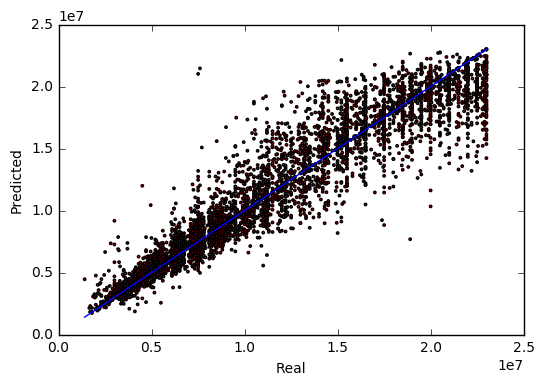

In [10]:
plt.scatter(Y_test_ALL,Y_test_pred_ALL,c='r',s=3*np.ones(len(Y_test_ALL)))
#plt.set_markersize(sz)(3)
plt.plot(  [min(Y_test_ALL),max(Y_test_ALL)],[min(Y_test_ALL),max(Y_test_ALL)],c='b')
plt.xlabel('Real')
plt.ylabel('Predicted')
#plt.plot(  [0,max(Y_test)],[0-1e6,    max(Y_test)-1e6],c='b')
#plt.plot(  [0,max(Y_test)],[0+1e6,    max(Y_test)+1e6],c='b')

plt.show()

Balcony_int


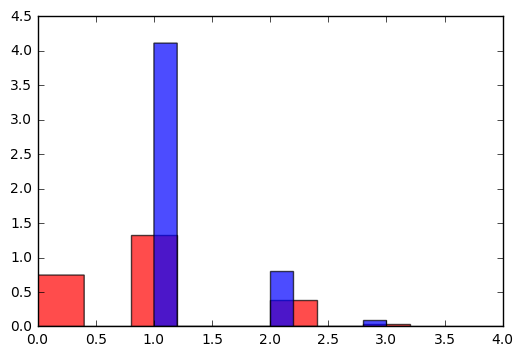

Built_year


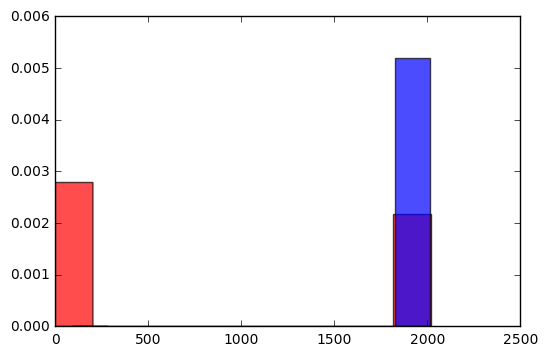

Floor


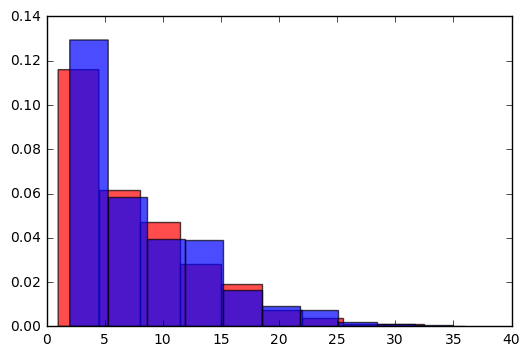

New_int


C:\Users\Artem\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:5991: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


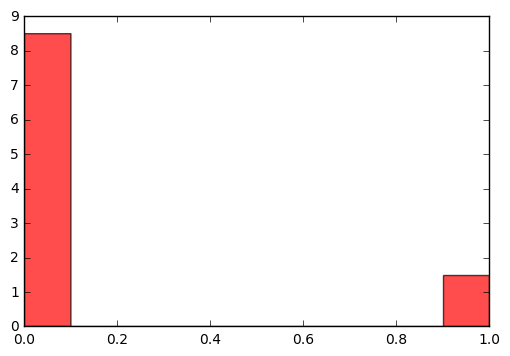

Lift_int


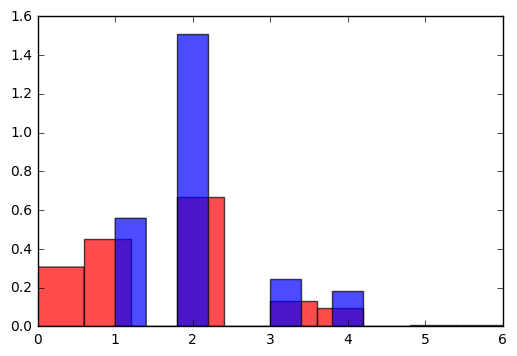

Nfloor


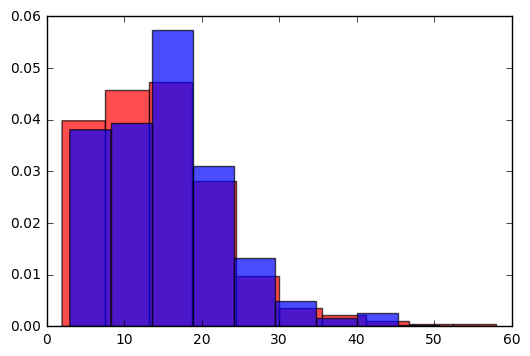

Roof_hight_fl


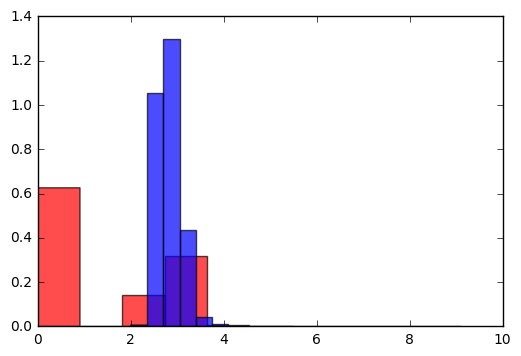

Totsp


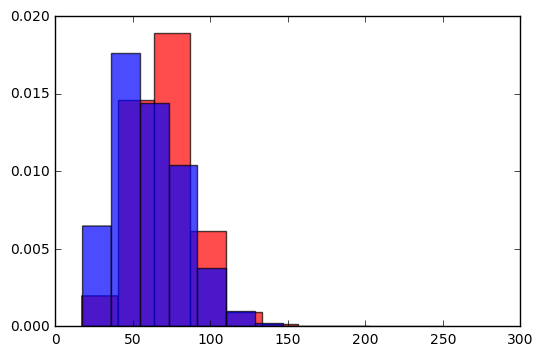

dist


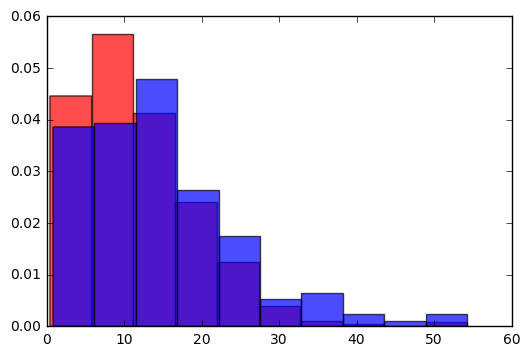

lat


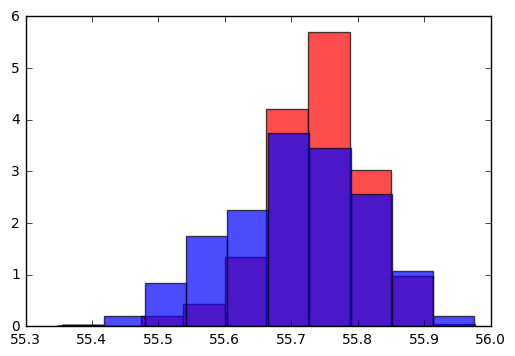

lon


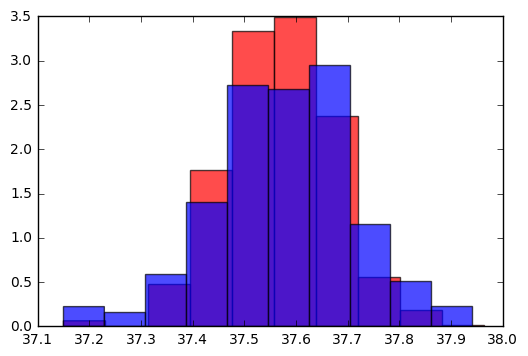

Kitsp


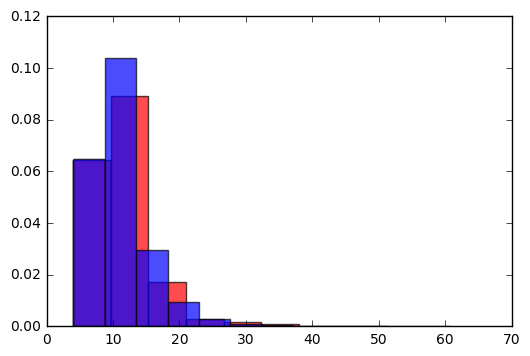

In [31]:
for feature in features:
    print(feature)
    outs = (Y_test_pred_ALL - Y_test_ALL)>2e6
    x_min = min(df_clean[outs][feature])
    x_max = max(df_clean[outs][feature])
    filt = (df_clean[feature]>x_min)&(df_clean[feature]<x_max)
    plt.hist(df_clean[outs][feature], normed=True,color='r',alpha=0.7)
    plt.hist(df_clean[filt][feature], normed=True,color='b',alpha=0.7)
    plt.show()

In [59]:
df_clean[ (Y_test_pred - Y_test)>5e6]

ValueError: Item wrong length 6182 instead of 18731.

In [11]:
feature_for_test = 'Totsp'
print(sum(df[feature_for_test].isnull()))
print(df[feature_for_test].value_counts())

0
60.0     272
75.0     236
54.0     206
80.0     206
40.0     169
70.0     169
39.0     159
38.0     155
45.0     150
52.0     150
55.0     147
76.0     146
64.0     141
65.0     140
78.0     134
74.0     132
58.0     131
56.0     124
50.0     118
53.0     115
35.0     110
32.0     107
73.0     104
100.0    104
42.0     102
33.0     101
72.0      95
77.0      94
59.0      93
68.0      92
        ... 
162.9      1
23.9       1
164.3      1
123.4      1
120.2      1
20.4       1
127.7      1
112.8      1
123.3      1
145.2      1
115.5      1
12.5       1
118.1      1
106.1      1
200.0      1
93.4       1
104.1      1
144.0      1
142.0      1
136.3      1
107.4      1
126.4      1
88.9       1
108.1      1
147.8      1
14.8       1
116.5      1
105.5      1
121.7      1
114.8      1
Name: Totsp, dtype: int64


In [12]:
features = ['Built_year','Floor',]

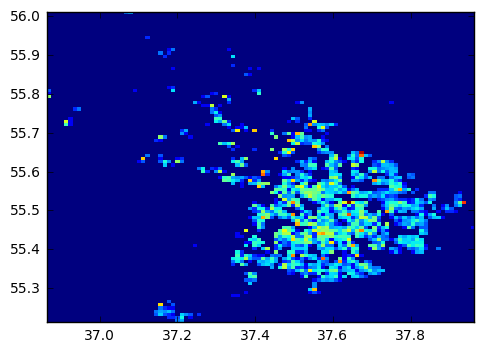

In [11]:
def heat_map(x,y):
    import numpy as np
    import matplotlib.pyplot as plt
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #print(heatmap)
    plt.clf()
    #plt.figure(figsize=(10,5))
    #plt.imshow(heatmap.T, extent=extent, origin='lower')
    #plt.show()
    plt.imshow(np.log2(heatmap.T+1), extent=extent,interpolation='nearest')
    plt.show()
    #plt.imshow(heatmap.T,extent=extent, interpolation='nearest')
    #plt.show()
heat_map(df[df['dist']<100]['lon'],df[df['dist']<100]['lat'])

In [73]:
from functools import reduce
def lol(a,b):
    return a*b
#reduce( (lambda x, y: x * y), [1, 2, 3, 4] )
reduce( lol, [2, 2, 3, 4] )

48

In [16]:
df.to_excel('a.xlsx')

In [42]:
from functools import reduce
from tqdm import tqdm
text =''
for el in  tqdm(df["Description"]):
    text+=el


100%|███████████████████████████████████████████████████████████████████████████| 15288/15288 [00:56<00:00, 268.80it/s]


In [50]:
import re
split_sim=' '
for el in ['\n',' ','\r','-',',',' ','\tb']:
    split_sim+=('|'+el)

text_splited = re.split(split_sim, text)

In [52]:
a =pd.Series(text_splited).value_counts()

In [13]:
from mpl_toolkits.basemap import Basemap, cm
# requires netcdf4-python (netcdf4-python.googlecode.com)
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt

# plot rainfall from NWS using special precipitation
# colormap used by the NWS, and included in basemap.

nc = NetCDFFile('../../../examples/nws_precip_conus_20061222.nc')
# data from http://water.weather.gov/precip/
prcpvar = nc.variables['amountofprecip']
data = 0.01*prcpvar[:]
latcorners = nc.variables['lat'][:]
loncorners = -nc.variables['lon'][:]
lon_0 = -nc.variables['true_lon'].getValue()
lat_0 = nc.variables['true_lat'].getValue()
# create figure and axes instances
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,\
            llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],\
            rsphere=6371200.,resolution='l',area_thresh=10000)
# draw coastlines, state and country boundaries, edge of map.
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
ny = data.shape[0]; nx = data.shape[1]
lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lons, lats) # compute map proj coordinates.
# draw filled contours.
clevs = [0,1,2.5,5,7.5,10,15,20,30,40,50,70,100,150,200,250,300,400,500,600,750]
cs = m.contourf(x,y,data,clevs,cmap=cm.s3pcpn)
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('mm')
# add title
plt.title(prcpvar.long_name+' for period ending '+prcpvar.dateofdata)
plt.show()

ImportError: No module named 'mpl_toolkits.basemap'

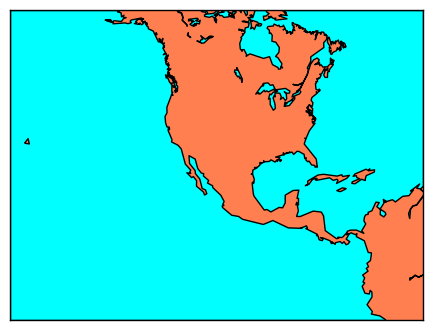

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=54.,lat_2=55,lat_0=30,lon_0=-107.)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
plt.show()

In [1]:
#get_data_from_page_PART3.py NEW!!!
import pandas as pd
import requests
import re
def html_stripper(text):
    return re.sub('<[^<]+?>', '', str(text))
from bs4 import BeautifulSoup



#Выдаёт не один элемент, а сразу небольшой словарь с переменными
def metro(flat_page,dic):
    #в sth (от англиского something) содержится много того, что нам нужно   
    # сколько миниут до метро и на машине или пешком
    sth = flat_page.find('span', attrs={'class':'object_item_metro_comment'})
    sth = html_stripper(sth)
    sth_list=sth.split('\n')
    sth_list = list(filter(None, sth_list))
    Metrdist = re.findall('\d+', sth)
    if len(Metrdist)==1:
        dic['Metro_time'] = int( Metrdist[0] )
    if 'пешком'in sth:
        dic['Walk_metro']=int(1)
    if 'машин' in sth:
        dic['Walk_metro']=int(0)
    # Станция метро
    sth = flat_page.find('a', attrs={'class':"object_item_metro_name"})
    sth = html_stripper(sth)
    dic["Metro_station"] = str(sth)
    
def add_feat4(dic,sth,spliter1,spliter2, key):
    #sth_list =str(sth).split(spliter)
    sth_list = re.split(spliter1+'|'+spliter2,sth)
    if len(sth_list)>1:
        dic[key] = sth_list[1]
    else:
        dic[key] = sth_list[0]

def many_get3(flat_page):
    #print(flat_page)
    dic ={}
    #Всякая хрень почти из подзаголовка
    sth = flat_page.find('span', attrs={'class':'object_descr_dt_added'})#.contents[1]
    sth=str(sth)
    #print(sth)
    add_feat4(dic=dic ,sth=sth ,spliter1='"deal_type": ',spliter2 = '"publication_date"',key= 'sale')
    add_feat4(dic=dic ,sth=sth ,spliter1='"publication_date": ',spliter2 = ', "id":',key= 'publication_date')
    add_feat4(dic=dic ,sth=sth ,spliter1='"is_premium":',spliter2 = '"deal_type":',key= 'is_premium')
    # Добавать ближайшую (первую в списке из ближайших) станций метро, время на способ добраться (пешком или на машине)
    metro(flat_page,dic)
    
    sth = flat_page.find('div', attrs={'class':'object_descr_text'})
    sth = html_stripper(sth)
    sth.replace('\n',' ')
    #print()
    dic['Description'] = re.sub(' +',' ',sth)
    return(dic)
def get_address(flat_page,dic):
    sth = flat_page.find('h1', attrs={'class':'object_descr_addr'})
    sth = html_stripper(sth)
    sth = sth.replace('\n',' ')
    sth = sth.replace('                       ',' ')
    dic['Address'] = sth
#link_number = 151535540
link_number = 150718150
flat_url = 'http://www.cian.ru/sale/flat/' + str(link_number) + '/'
flat_page = requests.get(flat_url)
flat_page = flat_page.content
flat_page = BeautifulSoup(flat_page, 'lxml')
get_address(flat_page)

TypeError: get_address() missing 1 required positional argument: 'dic'

In [3]:
flat_page

<!DOCTYPE html>
<html class="no-touch">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="Eig23WXwvPZu3gp9EYVreR61rG4TX1bHQDEG0Di5ZSE" name="google-site-verification"/>
<meta content="ЦИАН" name="apple-mobile-web-app-title"/>
<meta content="app-id=911804296, app-argument=https://www.cian.ru/sale/flat/151535540/" name="apple-itunes-app"/>
<link href="android-app://ru.cian.main/cian/offer/sale/flat/151535540/" rel="alternate"/>
<meta content="cian://sale/flat/151535540/" property="al:ios:url"/>
<meta content="911804296" property="al:ios:app_store_id"/>
<meta content="Cian" property="al:ios:app_name"/>
<meta content="https://www.cian.ru/sale/flat/151535540/" property="al:android:url"/>
<meta content="Cian" property="al:android:app_name"/>
<meta content="ru.cian.main" property="al:android:package"/>
<meta content="https://www.cian.ru/sale/flat/151535540/" property="al:web:url"/>
<meta content="website" property="og:type"/>
<meta content="CIAN" prope

In [19]:
test_map = Basemap(llcrnrlon=15.2,llcrnrlat=47.06,urcrnrlon=15.5, urcrnrlat=47.49, epsg = 31284,resolution='i',projection='merc',lon_0=14.8,lat_0=47.2)


test__map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 12000, verbose= True)

OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install -c conda-forge basemap-data-hires`.